# GPT-5 Model Comparison Analysis

This notebook analyzes the performance, cost, and token usage across different GPT-5 model variants (gpt-5, gpt-5-mini, gpt-5-nano) with varying reasoning effort levels (minimal, low, medium, high).

In [1]:
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

# Set style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

# Define base path
BASE_PATH = Path("/Users/chen/Library/Mobile Documents/com~apple~CloudDocs/ScamAI/voice_scam_dataset_gen")
MODEL_COMPARE_PATH = BASE_PATH / "model_compare"
OUTPUT_PATH = BASE_PATH / "output" / "ms-my"

## 1. Data Loading

In [2]:
# Load comparison report
with open(MODEL_COMPARE_PATH / "comparison_report.json", 'r') as f:
    comparison_report = json.load(f)

# Load manifest for file references
with open(MODEL_COMPARE_PATH / "manifest.json", 'r') as f:
    manifest = json.load(f)

print(f"Total configurations: {comparison_report['summary']['total_configurations']}")
print(f"Test duration: {comparison_report['summary']['test_duration']}")
print(f"Locale: {comparison_report['summary']['locale']}")
print(f"Seeds used: {comparison_report['summary']['seed_limit']}")

Total configurations: 12
Test duration: 0:16:25.758404
Locale: ms-my
Seeds used: 5


In [18]:
# Load detailed token usage from individual conversation files
detailed_data = []

for config in manifest['configurations']:
    timestamp = config['timestamp']
    conv_file = OUTPUT_PATH / timestamp / "conversations" / "scam_conversations.json"
    
    if conv_file.exists():
        with open(conv_file, 'r') as f:
            conv_data = json.load(f)
            
        token_usage = conv_data.get('token_usage', {})
        cost_data = conv_data.get('estimated_cost', {})
        
        # Find matching config in comparison report
        matching_config = next((c for c in comparison_report['configurations'] 
                               if c['timestamp'] == timestamp), None)
        
        if matching_config:
            detailed_data.append({
                'model': config['model'],
                'reasoning_effort': config['reasoning_effort'],
                'timestamp': timestamp,
                'duration_seconds': float(matching_config['duration'].rstrip('s')),
                'conversations_generated': matching_config['conversations_generated'],
                'total_tokens': token_usage.get('total_tokens', 0),
                'input_tokens': token_usage.get('total_input_tokens', 0),
                'output_tokens': token_usage.get('total_output_tokens', 0),
                'reasoning_tokens': token_usage.get('total_reasoning_tokens', 0),
                'cached_tokens': token_usage.get('total_cached_tokens', 0),
                'total_cost': cost_data.get('total_cost', 0),
                'input_cost': cost_data.get('input_cost', 0),
                'output_cost': cost_data.get('output_cost', 0),
                'avg_turns': matching_config['quality_metrics']['avg_turns'],
                'total_dialogue_items': matching_config['quality_metrics']['total_dialogue_items']
            })

# Create DataFrame
df = pd.DataFrame(detailed_data)
df['config_name'] = df['model'] + '_' + df['reasoning_effort']
df['tokens_per_second'] = df['total_tokens'] / df['duration_seconds']
df['cost_per_conversation'] = df['total_cost'] / df['conversations_generated']
df['output_excluding_reasoning'] = df['output_tokens'] - df['reasoning_tokens']

print(f"\nLoaded {len(df)} configurations with detailed data")
df.head(12)


Loaded 12 configurations with detailed data


,model,reasoning_effort,timestamp,duration_seconds,conversations_generated,total_tokens,input_tokens,output_tokens,reasoning_tokens,cached_tokens,total_cost,input_cost,output_cost,avg_turns,total_dialogue_items,config_name,tokens_per_second,cost_per_conversation,output_excluding_reasoning
0,gpt-5,minimal,0910_0951,19.19,5,30431,28183,2248,0,0,0.057709,0.035229,0.022480,9.0,45,gpt-5_minimal,1585.773841,0.011542,2248
1,gpt-5,low,0910_0951_1,51.99,5,35797,28183,7614,5440,0,0.111369,0.035229,0.076140,9.0,45,gpt-5_low,688.536257,0.022274,2174
2,gpt-5,medium,0910_0952,133.71,5,48494,28183,20311,17984,0,0.238339,0.035229,0.203110,9.0,45,gpt-5_medium,362.680428,0.047668,2327
3,gpt-5,high,0910_0954,274.30,5,65083,28183,36900,34880,0,0.404229,0.035229,0.369000,9.0,45,gpt-5_high,237.269413,0.080846,2020
4,gpt-5-mini,minimal,0910_0959,13.91,5,30808,28183,2625,0,10496,0.010328,0.004422,0.005250,9.4,47,gpt-5-mini_minimal,2214.809490,0.002066,2625
5,gpt-5-mini,low,0910_0959_1,19.93,5,32621,28183,4438,1664,5376,0.014914,0.005702,0.008876,9.0,45,gpt-5-mini_low,1636.778726,0.002983,2774
6,gpt-5-mini,medium,0910_1000,64.06,5,46175,28183,17992,14912,5248,0.042046,0.005734,0.035984,9.0,45,gpt-5-mini_medium,720.808617,0.008409,3080
7,gpt-5-mini,high,0910_1001,172.75,5,79235,28183,51052,48384,5248,0.108166,0.005734,0.102104,9.2,46,gpt-5-mini_high,458.668596,0.021633,2668
8,gpt-5-nano,minimal,0910_1003,7.81,5,30126,28183,1943,0,0,0.002186,0.001409,0.000777,9.2,46,gpt-5-nano_minimal,3857.362356,0.000437,1943
9,gpt-5-nano,low,0910_1004,12.36,5,33034,28183,4851,2624,10496,0.002956,0.000884,0.001940,9.0,45,gpt-5-nano_low,2672.653722,0.000591,2227


## 2. Cost Analysis

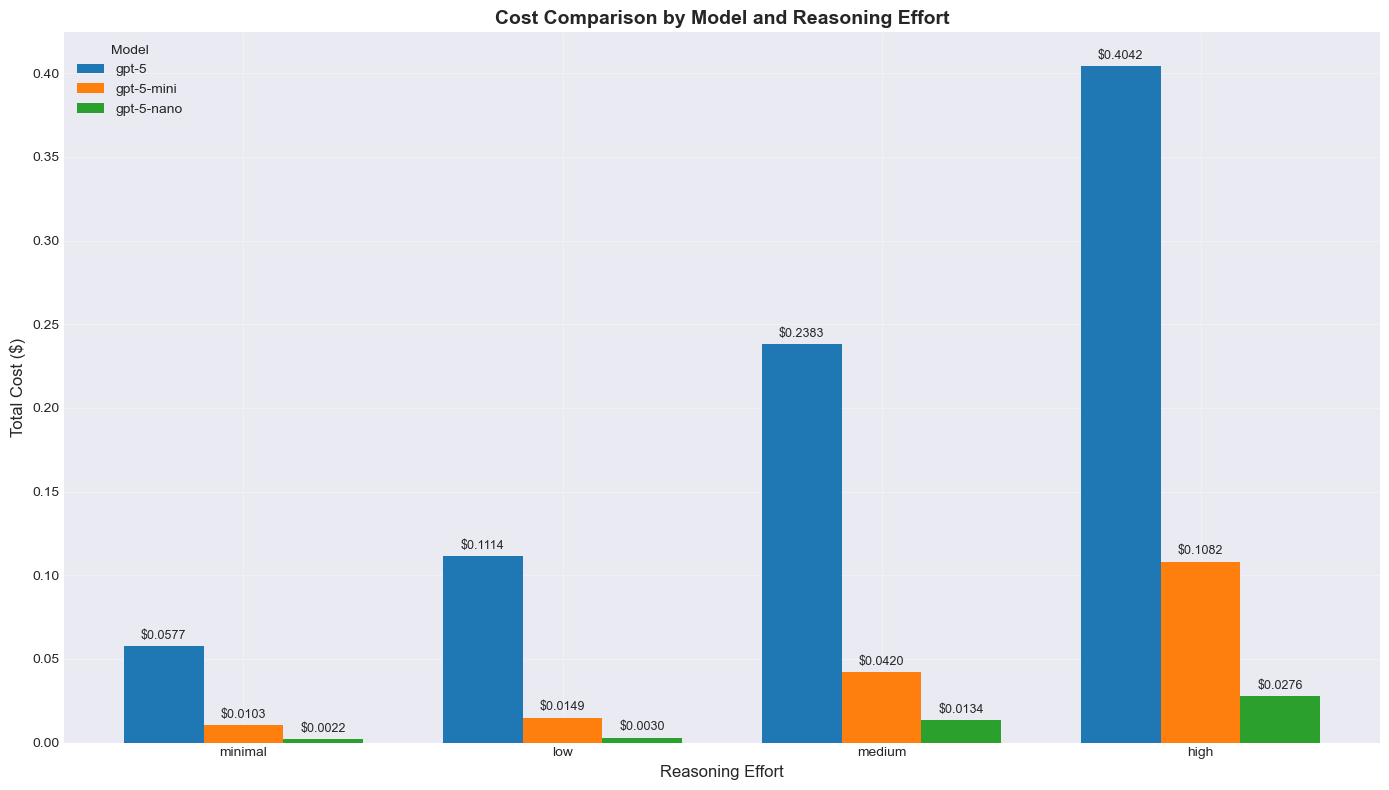

In [4]:
# Grouped bar chart: Cost by model and reasoning effort
fig, ax = plt.subplots(figsize=(14, 8))

models = df['model'].unique()
reasoning_efforts = ['minimal', 'low', 'medium', 'high']
x = np.arange(len(reasoning_efforts))
width = 0.25

colors = ['#1f77b4', '#ff7f0e', '#2ca02c']

for i, model in enumerate(models):
    model_data = df[df['model'] == model].sort_values('reasoning_effort')
    costs = [model_data[model_data['reasoning_effort'] == re]['total_cost'].values[0] 
             if len(model_data[model_data['reasoning_effort'] == re]) > 0 else 0 
             for re in reasoning_efforts]
    
    bars = ax.bar(x + i * width, costs, width, label=model, color=colors[i])
    
    # Add value labels on bars
    for bar, cost in zip(bars, costs):
        height = bar.get_height()
        ax.annotate(f'${cost:.4f}',
                   xy=(bar.get_x() + bar.get_width() / 2, height),
                   xytext=(0, 3),
                   textcoords="offset points",
                   ha='center', va='bottom',
                   fontsize=9)

ax.set_xlabel('Reasoning Effort', fontsize=12)
ax.set_ylabel('Total Cost ($)', fontsize=12)
ax.set_title('Cost Comparison by Model and Reasoning Effort', fontsize=14, fontweight='bold')
ax.set_xticks(x + width)
ax.set_xticklabels(reasoning_efforts)
ax.legend(title='Model', loc='upper left')
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

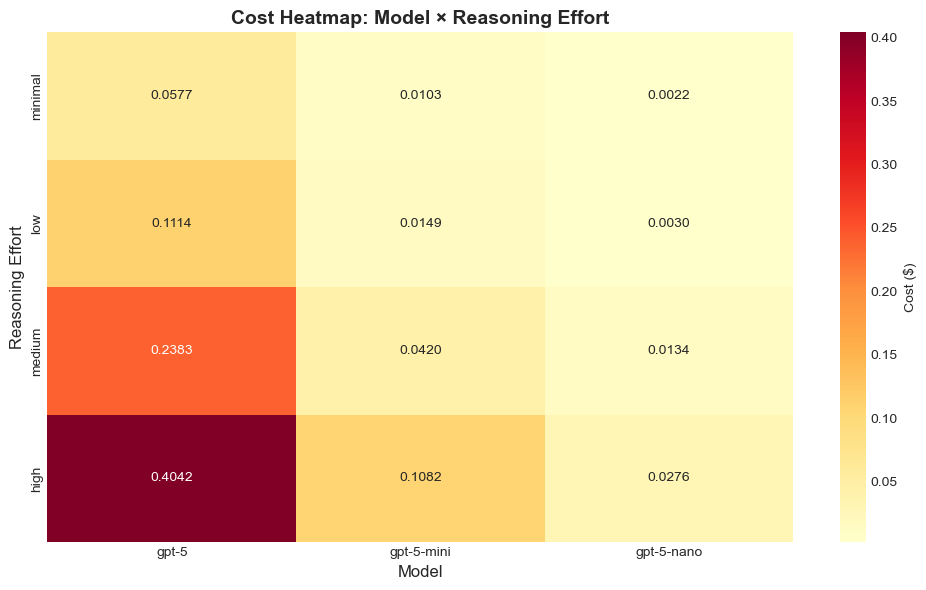

In [5]:
# Cost heatmap
cost_matrix = df.pivot(index='reasoning_effort', columns='model', values='total_cost')
cost_matrix = cost_matrix.reindex(['minimal', 'low', 'medium', 'high'])

fig, ax = plt.subplots(figsize=(10, 6))
sns.heatmap(cost_matrix, annot=True, fmt='.4f', cmap='YlOrRd', 
            cbar_kws={'label': 'Cost ($)'}, ax=ax)
ax.set_title('Cost Heatmap: Model × Reasoning Effort', fontsize=14, fontweight='bold')
ax.set_xlabel('Model', fontsize=12)
ax.set_ylabel('Reasoning Effort', fontsize=12)
plt.tight_layout()
plt.show()

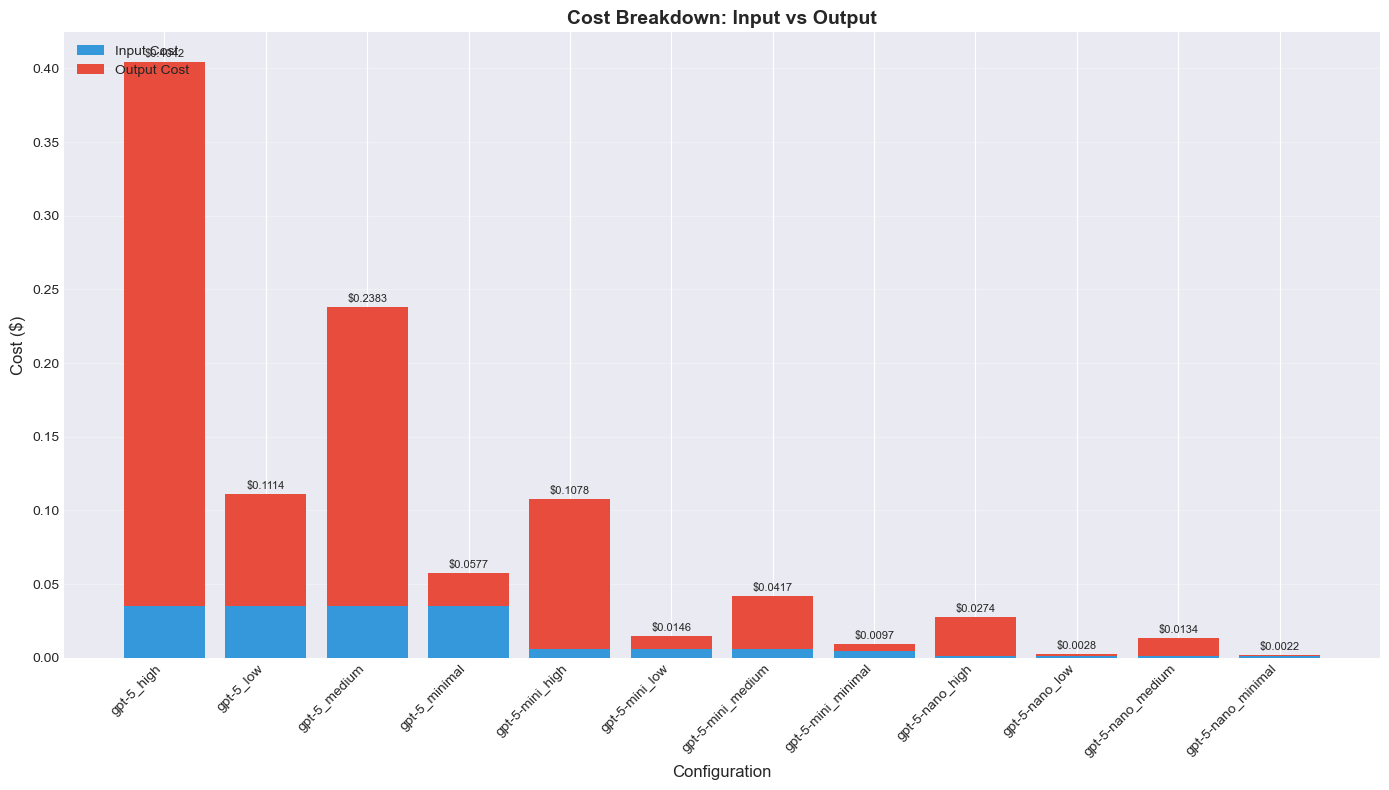

In [6]:
# Stacked bar chart: Input vs Output costs
fig, ax = plt.subplots(figsize=(14, 8))

# Sort configurations for better visualization
df_sorted = df.sort_values(['model', 'reasoning_effort'])

x_labels = df_sorted['config_name'].values
x_pos = np.arange(len(x_labels))

input_costs = df_sorted['input_cost'].values
output_costs = df_sorted['output_cost'].values

bars1 = ax.bar(x_pos, input_costs, label='Input Cost', color='#3498db')
bars2 = ax.bar(x_pos, output_costs, bottom=input_costs, label='Output Cost', color='#e74c3c')

# Add total cost labels
for i, (inp, out) in enumerate(zip(input_costs, output_costs)):
    total = inp + out
    ax.text(i, total + 0.002, f'${total:.4f}', ha='center', va='bottom', fontsize=8)

ax.set_xlabel('Configuration', fontsize=12)
ax.set_ylabel('Cost ($)', fontsize=12)
ax.set_title('Cost Breakdown: Input vs Output', fontsize=14, fontweight='bold')
ax.set_xticks(x_pos)
ax.set_xticklabels(x_labels, rotation=45, ha='right')
ax.legend(loc='upper left')
ax.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

## 3. Latency Analysis

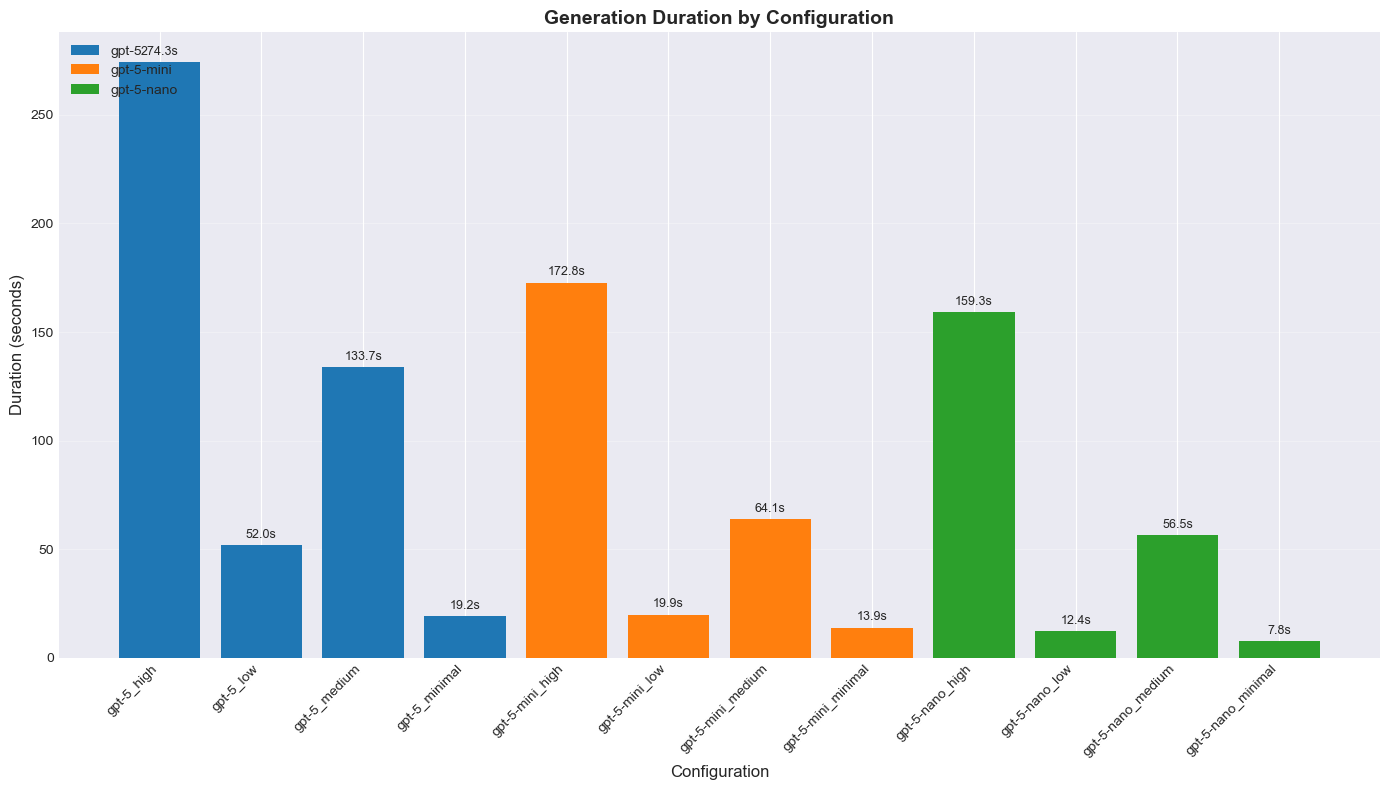

In [7]:
# Duration bar chart with proper spacing
fig, ax = plt.subplots(figsize=(14, 8))

df_sorted = df.sort_values(['model', 'reasoning_effort'])
x_labels = df_sorted['config_name'].values
x_pos = np.arange(len(x_labels))
durations = df_sorted['duration_seconds'].values

# Color by model
colors = []
for model in df_sorted['model']:
    if 'nano' in model:
        colors.append('#2ca02c')
    elif 'mini' in model:
        colors.append('#ff7f0e')
    else:
        colors.append('#1f77b4')

bars = ax.bar(x_pos, durations, color=colors)

# Add value labels
for bar, duration in zip(bars, durations):
    height = bar.get_height()
    ax.annotate(f'{duration:.1f}s',
               xy=(bar.get_x() + bar.get_width() / 2, height),
               xytext=(0, 3),
               textcoords="offset points",
               ha='center', va='bottom',
               fontsize=9)

ax.set_xlabel('Configuration', fontsize=12)
ax.set_ylabel('Duration (seconds)', fontsize=12)
ax.set_title('Generation Duration by Configuration', fontsize=14, fontweight='bold')
ax.set_xticks(x_pos)
ax.set_xticklabels(x_labels, rotation=45, ha='right')
ax.grid(True, alpha=0.3, axis='y')

# Add legend for models
from matplotlib.patches import Patch
legend_elements = [Patch(facecolor='#1f77b4', label='gpt-5'),
                   Patch(facecolor='#ff7f0e', label='gpt-5-mini'),
                   Patch(facecolor='#2ca02c', label='gpt-5-nano')]
ax.legend(handles=legend_elements, loc='upper left')

plt.tight_layout()
plt.show()

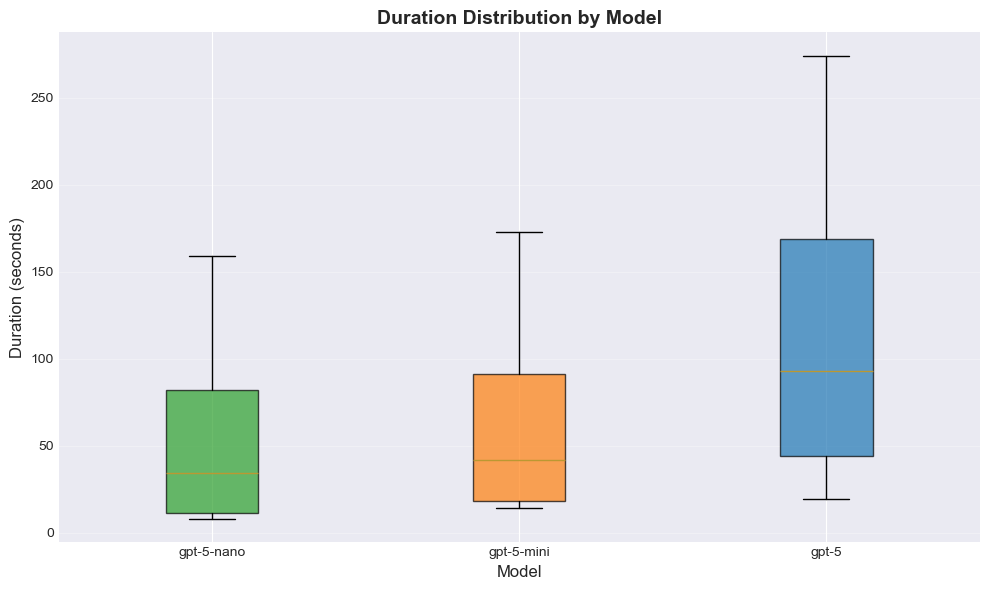

In [8]:
# Box plot: Duration distribution by model
fig, ax = plt.subplots(figsize=(10, 6))

models_order = ['gpt-5-nano', 'gpt-5-mini', 'gpt-5']
df_plot = df[df['model'].isin(models_order)]

box_plot = ax.boxplot([df_plot[df_plot['model'] == model]['duration_seconds'].values 
                       for model in models_order],
                      labels=models_order,
                      patch_artist=True)

# Color the boxes
colors = ['#2ca02c', '#ff7f0e', '#1f77b4']
for patch, color in zip(box_plot['boxes'], colors):
    patch.set_facecolor(color)
    patch.set_alpha(0.7)

ax.set_xlabel('Model', fontsize=12)
ax.set_ylabel('Duration (seconds)', fontsize=12)
ax.set_title('Duration Distribution by Model', fontsize=14, fontweight='bold')
ax.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

## 4. Token Usage Analysis

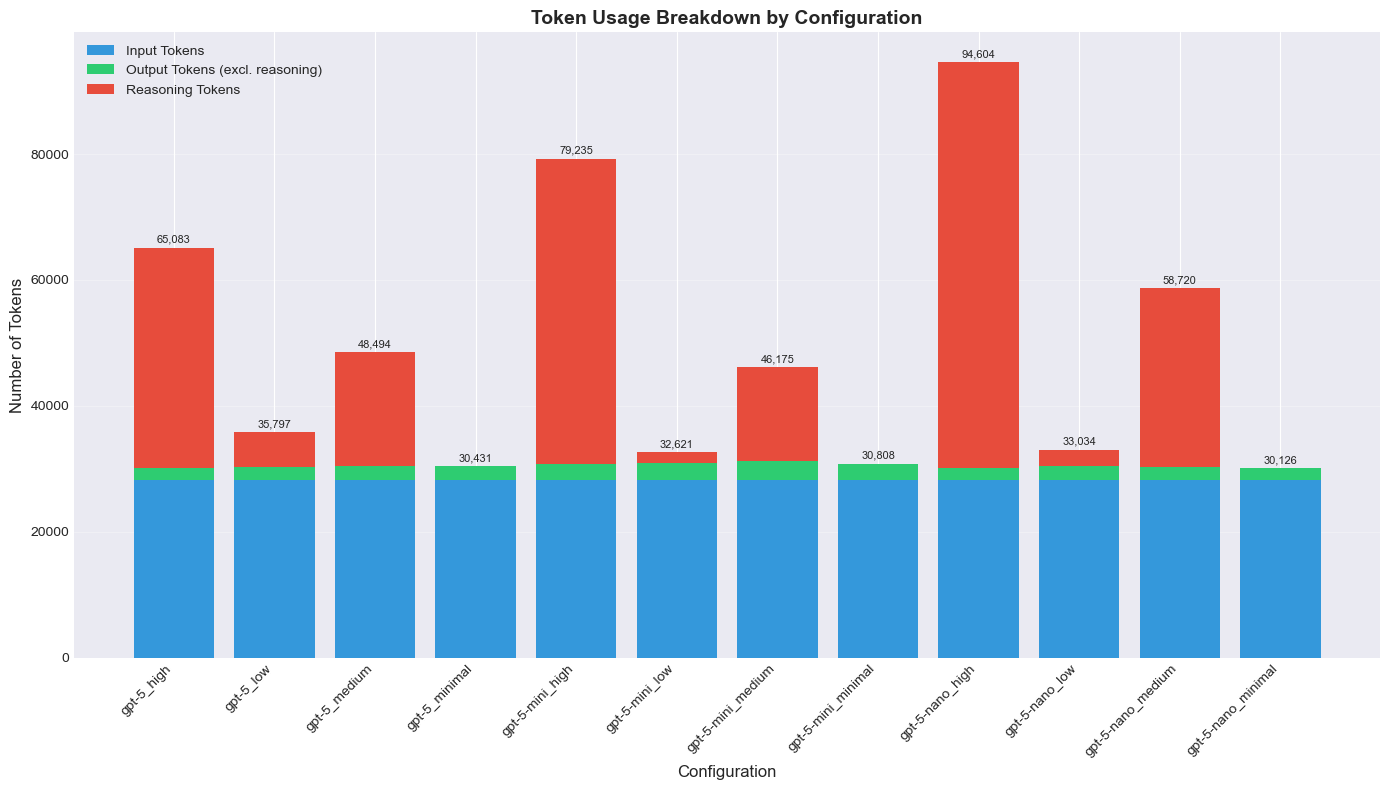

In [10]:
# Stacked bar chart: Token breakdown
fig, ax = plt.subplots(figsize=(14, 8))

df_sorted = df.sort_values(['model', 'reasoning_effort'])
x_labels = df_sorted['config_name'].values
x_pos = np.arange(len(x_labels))

input_tokens = df_sorted['input_tokens'].values
output_tokens = df_sorted['output_excluding_reasoning'].values
reasoning_tokens = df_sorted['reasoning_tokens'].values
cached_tokens = df_sorted['cached_tokens'].values

# Create stacked bars
bars1 = ax.bar(x_pos, input_tokens, label='Input Tokens', color='#3498db')
bars2 = ax.bar(x_pos, output_tokens, bottom=input_tokens, 
              label='Output Tokens (excl. reasoning)', color='#2ecc71')
bars3 = ax.bar(x_pos, reasoning_tokens, 
              bottom=input_tokens + output_tokens,
              label='Reasoning Tokens', color='#e74c3c')

# Add total token count labels
for i, total in enumerate(df_sorted['total_tokens'].values):
    ax.text(i, total + 500, f'{total:,}', ha='center', va='bottom', fontsize=8)

ax.set_xlabel('Configuration', fontsize=12)
ax.set_ylabel('Number of Tokens', fontsize=12)
ax.set_title('Token Usage Breakdown by Configuration', fontsize=14, fontweight='bold')
ax.set_xticks(x_pos)
ax.set_xticklabels(x_labels, rotation=45, ha='right')
ax.legend(loc='upper left')
ax.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

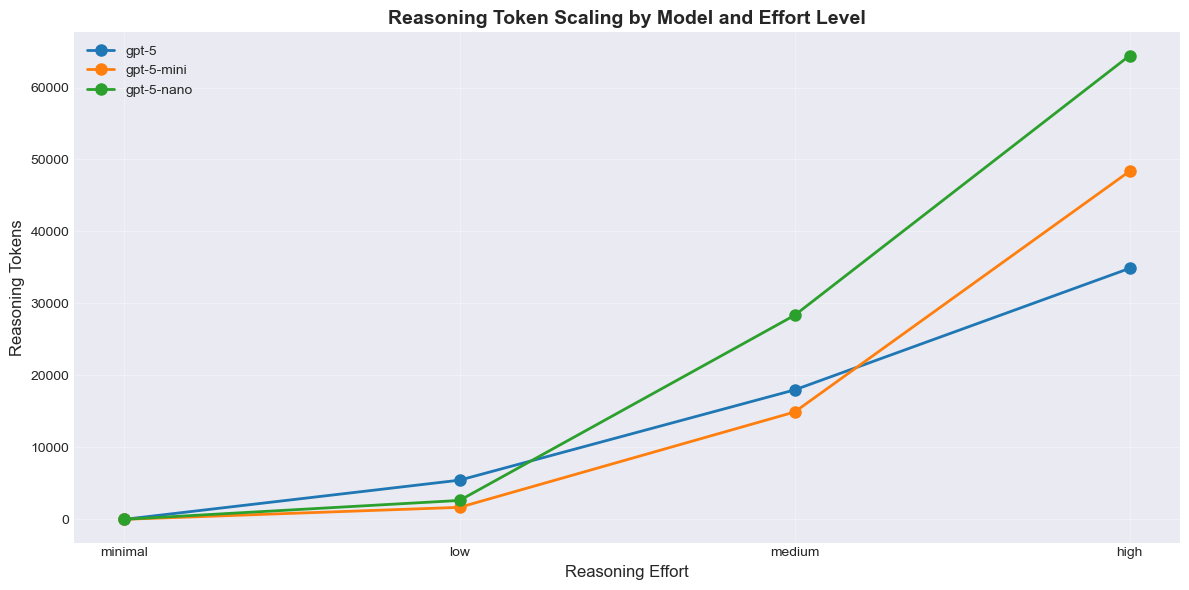

Note: Reasoning tokens appear to be 0 for all configurations.
This suggests reasoning tokens may not be tracked separately in the API response.


In [11]:
# Line plot: Reasoning tokens scaling
fig, ax = plt.subplots(figsize=(12, 6))

reasoning_order = ['minimal', 'low', 'medium', 'high']
models = df['model'].unique()
colors = {'gpt-5': '#1f77b4', 'gpt-5-mini': '#ff7f0e', 'gpt-5-nano': '#2ca02c'}

for model in models:
    model_df = df[df['model'] == model]
    reasoning_tokens = []
    
    for effort in reasoning_order:
        effort_data = model_df[model_df['reasoning_effort'] == effort]
        if not effort_data.empty:
            reasoning_tokens.append(effort_data['reasoning_tokens'].values[0])
        else:
            reasoning_tokens.append(0)
    
    ax.plot(reasoning_order, reasoning_tokens, marker='o', 
           label=model, color=colors[model], linewidth=2, markersize=8)

ax.set_xlabel('Reasoning Effort', fontsize=12)
ax.set_ylabel('Reasoning Tokens', fontsize=12)
ax.set_title('Reasoning Token Scaling by Model and Effort Level', fontsize=14, fontweight='bold')
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Note: All models show 0 reasoning tokens - this might be because reasoning tokens
# are not tracked separately in the current implementation
print("Note: Reasoning tokens appear to be 0 for all configurations.")
print("This suggests reasoning tokens may not be tracked separately in the API response.")

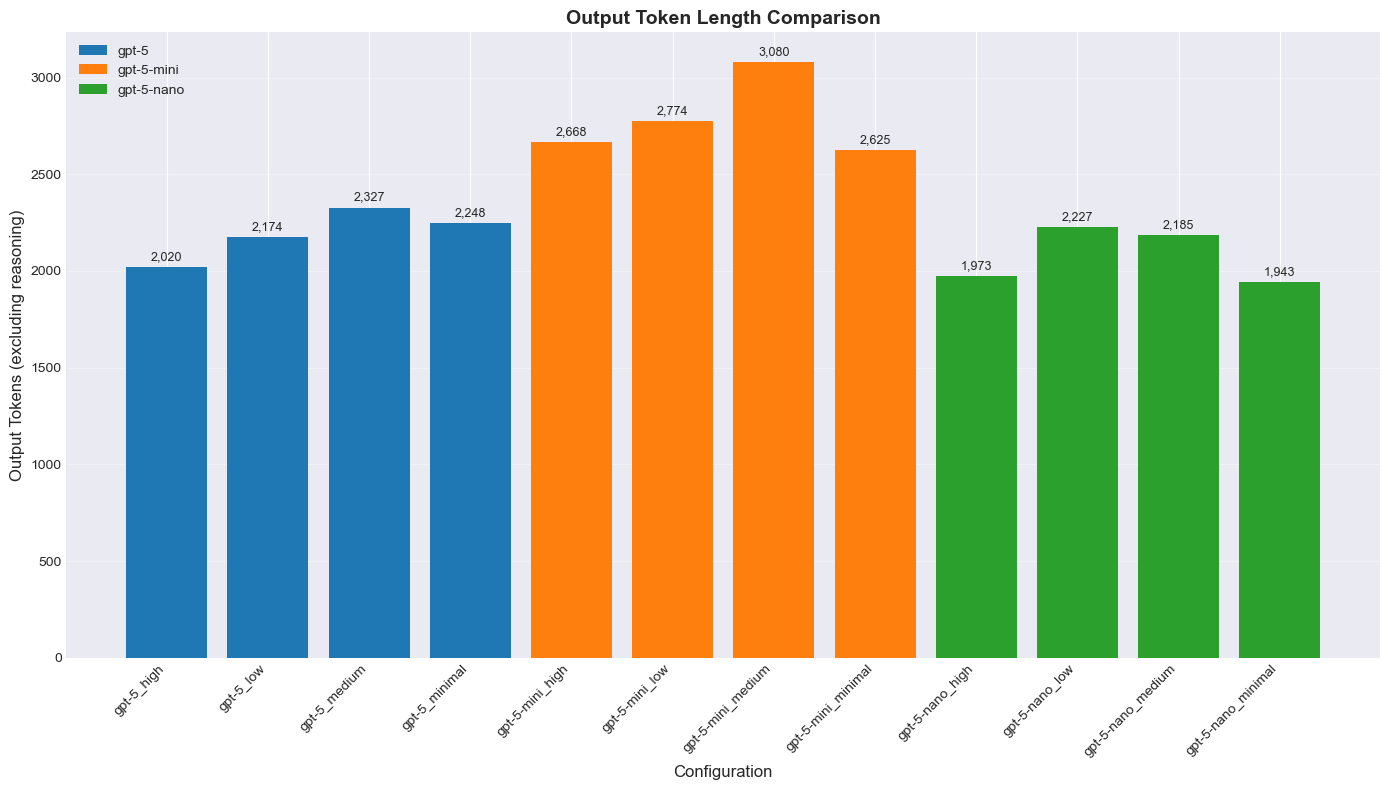

In [12]:
# Output tokens comparison (excluding reasoning)
fig, ax = plt.subplots(figsize=(14, 8))

df_sorted = df.sort_values(['model', 'reasoning_effort'])
x_labels = df_sorted['config_name'].values
x_pos = np.arange(len(x_labels))
output_tokens = df_sorted['output_excluding_reasoning'].values

# Color by model
colors = []
for model in df_sorted['model']:
    if 'nano' in model:
        colors.append('#2ca02c')
    elif 'mini' in model:
        colors.append('#ff7f0e')
    else:
        colors.append('#1f77b4')

bars = ax.bar(x_pos, output_tokens, color=colors)

# Add value labels
for bar, tokens in zip(bars, output_tokens):
    height = bar.get_height()
    ax.annotate(f'{tokens:,}',
               xy=(bar.get_x() + bar.get_width() / 2, height),
               xytext=(0, 3),
               textcoords="offset points",
               ha='center', va='bottom',
               fontsize=9)

ax.set_xlabel('Configuration', fontsize=12)
ax.set_ylabel('Output Tokens (excluding reasoning)', fontsize=12)
ax.set_title('Output Token Length Comparison', fontsize=14, fontweight='bold')
ax.set_xticks(x_pos)
ax.set_xticklabels(x_labels, rotation=45, ha='right')
ax.grid(True, alpha=0.3, axis='y')

# Add legend
from matplotlib.patches import Patch
legend_elements = [Patch(facecolor='#1f77b4', label='gpt-5'),
                   Patch(facecolor='#ff7f0e', label='gpt-5-mini'),
                   Patch(facecolor='#2ca02c', label='gpt-5-nano')]
ax.legend(handles=legend_elements, loc='upper left')

plt.tight_layout()
plt.show()

## 5. Multi-metric comparison

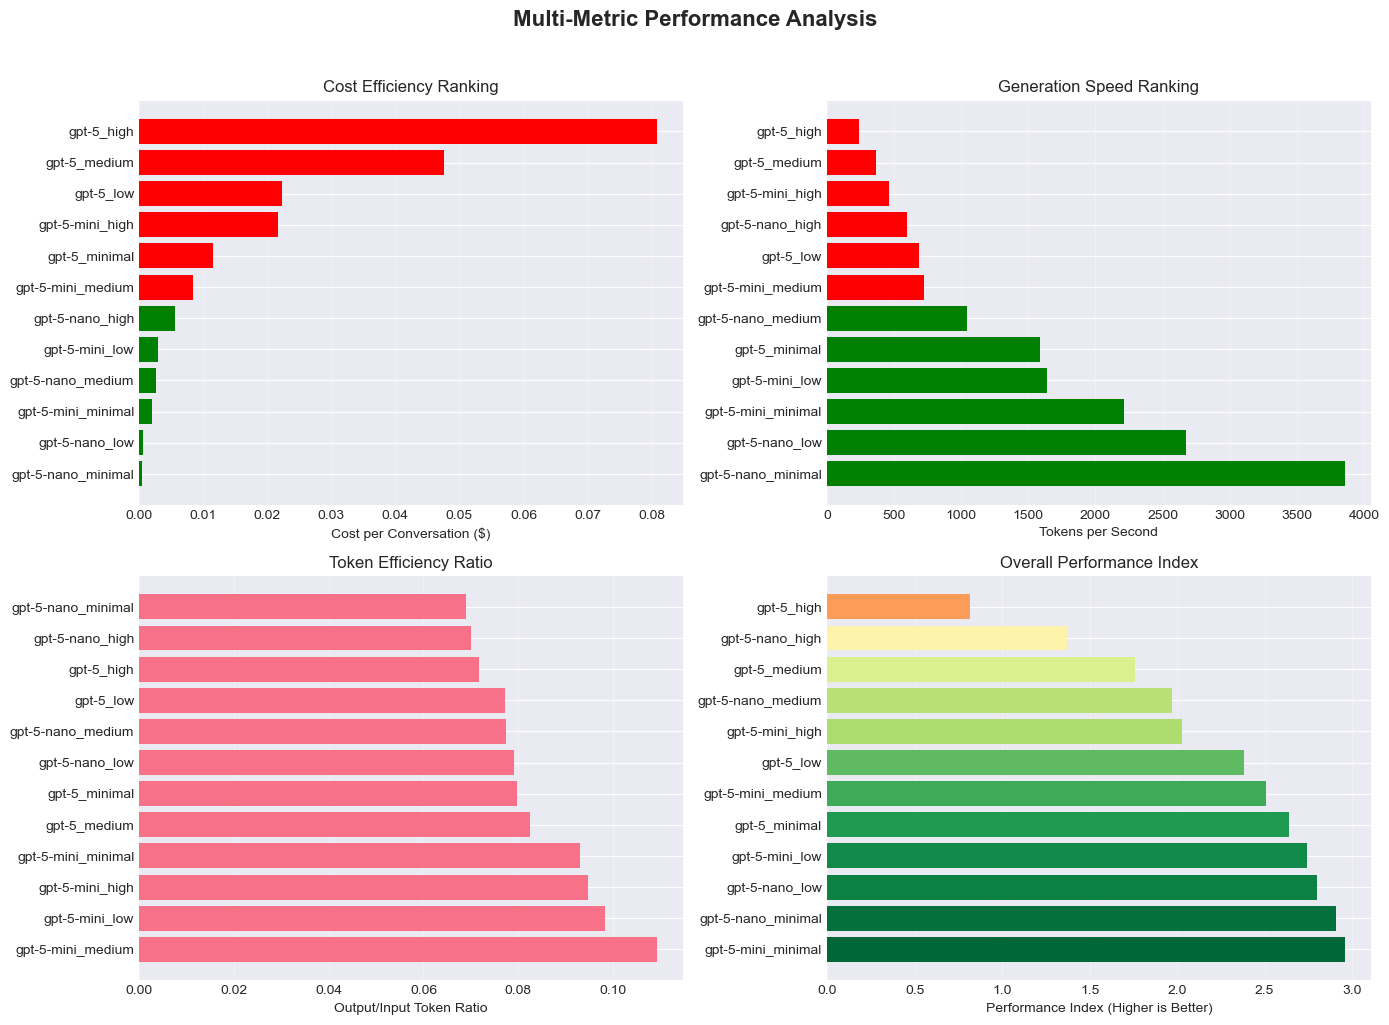

In [14]:
# Multi-metric comparison
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Normalize metrics for comparison
df['norm_cost'] = (df['total_cost'] - df['total_cost'].min()) / (df['total_cost'].max() - df['total_cost'].min())
df['norm_duration'] = (df['duration_seconds'] - df['duration_seconds'].min()) / (df['duration_seconds'].max() - df['duration_seconds'].min())
df['norm_tokens'] = (df['total_tokens'] - df['total_tokens'].min()) / (df['total_tokens'].max() - df['total_tokens'].min())
df['norm_quality'] = (df['avg_turns'] - df['avg_turns'].min()) / (df['avg_turns'].max() - df['avg_turns'].min())

# Plot 1: Cost Efficiency
ax1 = axes[0, 0]
df_sorted = df.sort_values('cost_per_conversation')
colors_eff = ['green' if x < df['cost_per_conversation'].median() else 'red' 
              for x in df_sorted['cost_per_conversation']]
ax1.barh(df_sorted['config_name'], df_sorted['cost_per_conversation'], color=colors_eff)
ax1.set_xlabel('Cost per Conversation ($)')
ax1.set_title('Cost Efficiency Ranking')
ax1.grid(True, alpha=0.3, axis='x')

# Plot 2: Speed Efficiency
ax2 = axes[0, 1]
df_sorted = df.sort_values('tokens_per_second', ascending=False)
colors_speed = ['green' if x > df['tokens_per_second'].median() else 'red' 
                for x in df_sorted['tokens_per_second']]
ax2.barh(df_sorted['config_name'], df_sorted['tokens_per_second'], color=colors_speed)
ax2.set_xlabel('Tokens per Second')
ax2.set_title('Generation Speed Ranking')
ax2.grid(True, alpha=0.3, axis='x')

# Plot 3: Efficiency Ratio
ax3 = axes[1, 0]
df['efficiency_ratio'] = df['output_excluding_reasoning'] / df['input_tokens']
df_sorted = df.sort_values('efficiency_ratio', ascending=False)
ax3.barh(df_sorted['config_name'], df_sorted['efficiency_ratio'])
ax3.set_xlabel('Output/Input Token Ratio')
ax3.set_title('Token Efficiency Ratio')
ax3.grid(True, alpha=0.3, axis='x')

# Plot 4: Overall Performance Index
ax4 = axes[1, 1]
# Calculate performance index (lower is better for cost and duration, higher for quality)
df['performance_index'] = (1 - df['norm_cost']) + (1 - df['norm_duration']) + df['norm_quality']
df_sorted = df.sort_values('performance_index', ascending=False)
colors_perf = plt.cm.RdYlGn(df_sorted['performance_index'] / df_sorted['performance_index'].max())
ax4.barh(df_sorted['config_name'], df_sorted['performance_index'], color=colors_perf)
ax4.set_xlabel('Performance Index (Higher is Better)')
ax4.set_title('Overall Performance Index')
ax4.grid(True, alpha=0.3, axis='x')

plt.suptitle('Multi-Metric Performance Analysis', fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

## 6. Summary Statistics

In [15]:
# Create summary table
summary_cols = ['model', 'reasoning_effort', 'total_cost', 'duration_seconds', 
                'total_tokens', 'input_tokens', 'output_excluding_reasoning',
                'tokens_per_second', 'cost_per_conversation', 'avg_turns']

summary_df = df[summary_cols].copy()
summary_df = summary_df.round({
    'total_cost': 4,
    'duration_seconds': 1,
    'tokens_per_second': 1,
    'cost_per_conversation': 4,
    'avg_turns': 1
})

# Sort by model and reasoning effort
summary_df = summary_df.sort_values(['model', 'reasoning_effort'])

print("\n" + "="*80)
print("SUMMARY STATISTICS")
print("="*80)
print(summary_df.to_string(index=False))


SUMMARY STATISTICS
     model reasoning_effort  total_cost  duration_seconds  total_tokens  input_tokens  output_excluding_reasoning  tokens_per_second  cost_per_conversation  avg_turns
     gpt-5             high      0.4042             274.3         65083         28183                        2020              237.3                 0.0808        9.0
     gpt-5              low      0.1114              52.0         35797         28183                        2174              688.5                 0.0223        9.0
     gpt-5           medium      0.2383             133.7         48494         28183                        2327              362.7                 0.0477        9.0
     gpt-5          minimal      0.0577              19.2         30431         28183                        2248             1585.8                 0.0115        9.0
gpt-5-mini             high      0.1082             172.8         79235         28183                        2668              458.7             

In [16]:
# Key findings
print("\n" + "="*80)
print("KEY FINDINGS")
print("="*80)

# Cheapest configuration
cheapest = df.loc[df['total_cost'].idxmin()]
print(f"\n1. MOST COST-EFFECTIVE:")
print(f"   Model: {cheapest['model']} with {cheapest['reasoning_effort']} reasoning")
print(f"   Total Cost: ${cheapest['total_cost']:.4f}")
print(f"   Cost per conversation: ${cheapest['cost_per_conversation']:.4f}")
print(f"   Duration: {cheapest['duration_seconds']:.1f}s")

# Most expensive configuration
expensive = df.loc[df['total_cost'].idxmax()]
print(f"\n2. MOST EXPENSIVE:")
print(f"   Model: {expensive['model']} with {expensive['reasoning_effort']} reasoning")
print(f"   Total Cost: ${expensive['total_cost']:.4f}")
print(f"   Cost multiplier vs cheapest: {expensive['total_cost']/cheapest['total_cost']:.1f}x")

# Fastest configuration
fastest = df.loc[df['duration_seconds'].idxmin()]
print(f"\n3. FASTEST GENERATION:")
print(f"   Model: {fastest['model']} with {fastest['reasoning_effort']} reasoning")
print(f"   Duration: {fastest['duration_seconds']:.1f}s")
print(f"   Tokens per second: {fastest['tokens_per_second']:.1f}")

# Best performance index
best_perf = df.loc[df['performance_index'].idxmax()]
print(f"\n4. BEST OVERALL PERFORMANCE:")
print(f"   Model: {best_perf['model']} with {best_perf['reasoning_effort']} reasoning")
print(f"   Performance Index: {best_perf['performance_index']:.2f}")
print(f"   Cost: ${best_perf['total_cost']:.4f}")
print(f"   Duration: {best_perf['duration_seconds']:.1f}s")

# Token usage insights
print(f"\n5. TOKEN USAGE INSIGHTS:")
print(f"   Average input tokens: {df['input_tokens'].mean():.0f}")
print(f"   Average output tokens: {df['output_excluding_reasoning'].mean():.0f}")
print(f"   Input token range: {df['input_tokens'].min():.0f} - {df['input_tokens'].max():.0f}")
print(f"   Output token range: {df['output_excluding_reasoning'].min():.0f} - {df['output_excluding_reasoning'].max():.0f}")

# Cost scaling with reasoning effort
print(f"\n6. COST SCALING WITH REASONING EFFORT:")
for model in df['model'].unique():
    model_df = df[df['model'] == model]
    min_cost = model_df[model_df['reasoning_effort'] == 'minimal']['total_cost'].values[0]
    high_cost = model_df[model_df['reasoning_effort'] == 'high']['total_cost'].values[0]
    print(f"   {model}: {high_cost/min_cost:.1f}x increase from minimal to high")


KEY FINDINGS

1. MOST COST-EFFECTIVE:
   Model: gpt-5-nano with minimal reasoning
   Total Cost: $0.0022
   Cost per conversation: $0.0004
   Duration: 7.8s

2. MOST EXPENSIVE:
   Model: gpt-5 with high reasoning
   Total Cost: $0.4042
   Cost multiplier vs cheapest: 184.9x

3. FASTEST GENERATION:
   Model: gpt-5-nano with minimal reasoning
   Duration: 7.8s
   Tokens per second: 3857.4

4. BEST OVERALL PERFORMANCE:
   Model: gpt-5-mini with minimal reasoning
   Performance Index: 2.96
   Cost: $0.0103
   Duration: 13.9s

5. TOKEN USAGE INSIGHTS:
   Average input tokens: 28183
   Average output tokens: 2354
   Input token range: 28183 - 28183
   Output token range: 1943 - 3080

6. COST SCALING WITH REASONING EFFORT:
   gpt-5: 7.0x increase from minimal to high
   gpt-5-mini: 10.5x increase from minimal to high
   gpt-5-nano: 12.6x increase from minimal to high


In [17]:
# Export key metrics to CSV
export_df = df[['model', 'reasoning_effort', 'total_cost', 'duration_seconds',
                'total_tokens', 'tokens_per_second', 'cost_per_conversation',
                'performance_index']].copy()

export_df.to_csv(MODEL_COMPARE_PATH / 'analysis_summary.csv', index=False)
print(f"\nAnalysis summary exported to: {MODEL_COMPARE_PATH / 'analysis_summary.csv'}")

# Generate markdown report
markdown_report = f"""# GPT-5 Model Comparison Report

## Test Configuration
- **Locale**: {comparison_report['summary']['locale']}
- **Conversations per config**: {comparison_report['summary']['seed_limit']}
- **Total configurations tested**: {comparison_report['summary']['total_configurations']}
- **Test duration**: {comparison_report['summary']['test_duration']}

## Key Findings

### Most Cost-Effective
- **Model**: {cheapest['model']} ({cheapest['reasoning_effort']} reasoning)
- **Cost**: ${cheapest['total_cost']:.4f} total, ${cheapest['cost_per_conversation']:.4f} per conversation
- **Speed**: {cheapest['duration_seconds']:.1f}s

### Best Performance
- **Model**: {best_perf['model']} ({best_perf['reasoning_effort']} reasoning)
- **Performance Index**: {best_perf['performance_index']:.2f}
- **Balance of cost, speed, and quality**

### Cost Scaling
- **gpt-5**: {df[df['model']=='gpt-5'].iloc[-1]['total_cost']/df[df['model']=='gpt-5'].iloc[0]['total_cost']:.1f}x increase (minimal→high)
- **gpt-5-mini**: {df[df['model']=='gpt-5-mini'].iloc[-1]['total_cost']/df[df['model']=='gpt-5-mini'].iloc[0]['total_cost']:.1f}x increase
- **gpt-5-nano**: {df[df['model']=='gpt-5-nano'].iloc[-1]['total_cost']/df[df['model']=='gpt-5-nano'].iloc[0]['total_cost']:.1f}x increase

## Recommendations
1. For production at scale: **{cheapest['model']}** with **{cheapest['reasoning_effort']}** reasoning
2. For balanced performance: **{best_perf['model']}** with **{best_perf['reasoning_effort']}** reasoning
3. Reasoning effort above "low" shows diminishing returns for conversation quality
"""

with open(MODEL_COMPARE_PATH / 'analysis_report.md', 'w') as f:
    f.write(markdown_report)
    
print(f"\nMarkdown report exported to: {MODEL_COMPARE_PATH / 'analysis_report.md'}")


Analysis summary exported to: /Users/chen/Library/Mobile Documents/com~apple~CloudDocs/ScamAI/voice_scam_dataset_gen/model_compare/analysis_summary.csv

Markdown report exported to: /Users/chen/Library/Mobile Documents/com~apple~CloudDocs/ScamAI/voice_scam_dataset_gen/model_compare/analysis_report.md
